In [22]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])
pysim_root = "/home/emmanuel/code/pysim"
# append to path
sys.path.append(str(root))
sys.path.append(str(pysim_root))


import numpy as np

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns

sns.set_context(context="poster", font_scale=0.7)

%load_ext autoreload
%autoreload 2
%load_ext lab_black

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


## Entropy

In [2]:
from pysim.data.information.gaussian import (
    generate_gaussian_data,
    generate_gaussian_rotation_data,
)
from pysim.data.information.linear import generate_linear_entropy_data
from pysim.information.histogram import hist_entropy
from pysim.information.entropy import marginal_entropy
from functools import partial

In [3]:
n_samples = 50_000
n_features = 2
seed = 123

# create marginal entropy estimator
f = partial(marginal_entropy, estimator=hist_entropy, bins="sqrt", correction=None)

# create seed (trial number)
res_dict = generate_linear_entropy_data(
    n_samples=n_samples,
    n_features=n_features,
    seed=seed,
    marg_h_estimator=f,
    estimator_name="histogram",
    n_base_samples=500_000,
)

res_dict.H

2.3529096902887097

## Demo

### Estimators

In [4]:
from pysim.information.gaussian import gauss_entropy_multi
from pysim.information.knn import knn_entropy, knn_entropy_npeet
import time


def get_entropy_estimators(data):

    t0 = time.time()
    H_g = gauss_entropy_multi(data)
    print(f"Gaussian: {H_g:.4f} | Time: {time.time()-t0:.4f} secs")

    t0 = time.time()
    H_knn_nbs = knn_entropy(X=data, n_neighbors=10, base=2)
    print(f"KNN (Neighbours): {H_knn_nbs:.4f} | Time: {time.time()-t0:.4f} secs")

    t0 = time.time()
    H_knn_eps = knn_entropy_npeet(X=data, n_neighbors=10, base=2)
    print(f"KNN (epsilon): {H_knn_eps:.4f} | Time: {time.time()-t0:.4f} secs")

In [5]:
get_entropy_estimators(res_dict.X.copy())

Gaussian: 3.7915 | Time: 0.0326 secs
KNN (Neighbours): 2.6766 | Time: 0.3002 secs
KNN (epsilon): 2.7663 | Time: 0.2330 secs


## Demo Experiment

In [73]:
from pysim.utils import dict_product

n_features = [2, 3, 5, 10, 50, 100]
n_samples = [500, 1_000, 5_000, 10_000, 50_000]
params_dict = {
    "n_features": n_features,
    "n_samples": n_samples,
    #     "n_features": n_features,
}

params_dict = dict_product(params_dict)
params_dict

[{'n_features': 2, 'n_samples': 500},
 {'n_features': 2, 'n_samples': 1000},
 {'n_features': 2, 'n_samples': 5000},
 {'n_features': 2, 'n_samples': 10000},
 {'n_features': 2, 'n_samples': 50000},
 {'n_features': 3, 'n_samples': 500},
 {'n_features': 3, 'n_samples': 1000},
 {'n_features': 3, 'n_samples': 5000},
 {'n_features': 3, 'n_samples': 10000},
 {'n_features': 3, 'n_samples': 50000},
 {'n_features': 5, 'n_samples': 500},
 {'n_features': 5, 'n_samples': 1000},
 {'n_features': 5, 'n_samples': 5000},
 {'n_features': 5, 'n_samples': 10000},
 {'n_features': 5, 'n_samples': 50000},
 {'n_features': 10, 'n_samples': 500},
 {'n_features': 10, 'n_samples': 1000},
 {'n_features': 10, 'n_samples': 5000},
 {'n_features': 10, 'n_samples': 10000},
 {'n_features': 10, 'n_samples': 50000},
 {'n_features': 50, 'n_samples': 500},
 {'n_features': 50, 'n_samples': 1000},
 {'n_features': 50, 'n_samples': 5000},
 {'n_features': 50, 'n_samples': 10000},
 {'n_features': 50, 'n_samples': 50000},
 {'n_featu

In [34]:
from tqdm.notebook import tqdm, trange
import pandas as pd
import itertools
import numpy as np

iteration = itertools.count()


all_stats = pd.DataFrame()


pbar_params = tqdm(params_dict, leave=True)

for i_params in pbar_params:

    i_features = i_params["n_features"]
    i_samples = i_params["n_samples"]

    pbar_params.set_description(f"Samples: {i_samples} | Features: {i_features} - ")

    results = {}

    pbar_trials = trange(n_trials, leave=False)

    for i_trial in pbar_trials:

        pbar_trials.set_description(f"Trials: {i_trial} | Method: GT")

        # generate data
        res_dict = generate_linear_entropy_data(
            n_samples=i_samples,
            n_features=i_features,
            seed=i_trial,
            marg_h_estimator=f,
            estimator_name="histogram",
            n_base_samples=500_000,
        )
        results = {
            "method": "truth",
            "n_samples": i_samples,
            "n_features": i_features,
            "trial": i_trial,
            "H": res_dict.H,
        }
        all_stats = pd.concat(
            [all_stats, pd.DataFrame(results, index=[next(iteration)])], axis=0
        )

        # ======================
        # Gaussian Estimation
        # ======================
        pbar_trials.set_description(f"Trials: {i_trial} | Method: Gaussian")

        output = gauss_entropy_multi(res_dict.X.copy())
        results = {
            "method": "gaussian",
            "n_samples": i_samples,
            "n_features": i_features,
            "trial": i_trial,
            "H": output,
        }

        all_stats = pd.concat(
            [all_stats, pd.DataFrame(results, index=[next(iteration)])], axis=0
        )

        # ==========================
        # KNN estimated (Neighbors)
        # ==========================

        pbar_trials.set_description(f"Trials: {i_trial} | Method: KNN (Neighbors)")

        output = knn_entropy(X=res_dict.X.copy(), n_neighbors=10, base=2, n_jobs=-1)

        results = {
            "method": "knn_nbs",
            "n_samples": i_samples,
            "n_features": i_features,
            "trial": i_trial,
            "H": output,
        }

        all_stats = pd.concat(
            [all_stats, pd.DataFrame(results, index=[next(iteration)])], axis=0
        )

        # ==========================
        # KNN estimated (Epsilon)
        # ==========================
        pbar_trials.set_description(f"Trials: {i_trial} | Method: KNN (Epsilon-Ball)")

        output = knn_entropy_npeet(
            X=res_dict.X.copy(), n_neighbors=10, base=2, n_jobs=-1
        )

        results = {
            "method": "knn_tree",
            "n_samples": i_samples,
            "n_features": i_features,
            "trial": i_trial,
            "H": output,
        }

        all_stats = pd.concat(
            [all_stats, pd.DataFrame(results, index=[next(iteration)])], axis=0
        )

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [35]:
all_stats_ = all_stats.copy()
all_stats_["algorithm"] = all_stats_["method"]
all_stats_ = all_stats_.drop(["method"], axis=1)

In [36]:
all_stats_ = all_stats_.set_index(["n_samples", "n_features", "trial", "algorithm"])

In [37]:
stats_ds = all_stats_.to_xarray()

In [38]:
stats_ds

<xarray.Dataset>
Dimensions:     (algorithm: 4, n_features: 1, n_samples: 5, trial: 10)
Coordinates:
  * n_samples   (n_samples) int64 500 1000 5000 10000 50000
  * n_features  (n_features) int64 10
  * trial       (trial) int64 0 1 2 3 4 5 6 7 8 9
  * algorithm   (algorithm) object 'gaussian' 'knn_nbs' 'knn_tree' 'truth'
Data variables:
    H           (n_samples, n_features, trial, algorithm) float64 9.819 ... 1...

## Plots

In [45]:
def percent_error(real, pred):
    pred = np.abs(np.abs(pred - real) / real)
    return pred


def get_mean_std(ds):
    mean = ds.mean(["trial"])
    std = ds.var(["trial"])
    return mean, std

### Compare Values

In [66]:
stats_ds.sel(n_features=10).H.min().values

array(9.74522753)

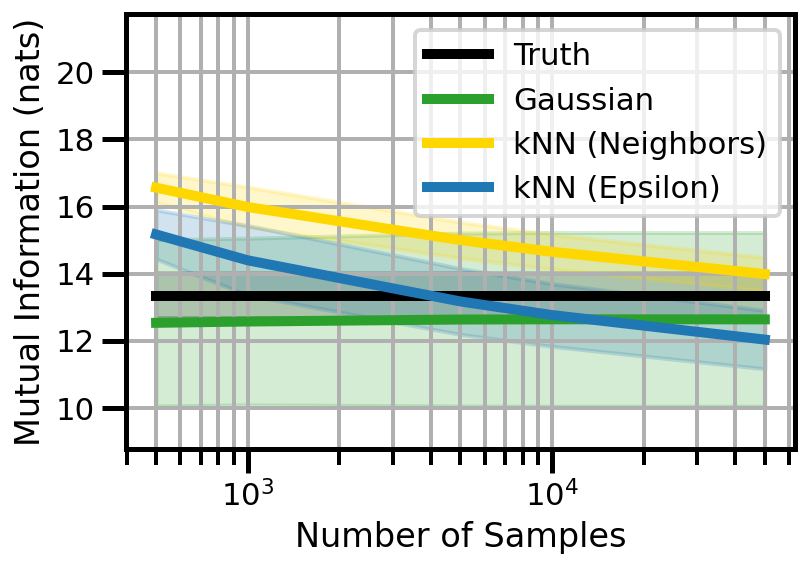

In [71]:
fig, ax = plt.subplots()

# ==========================
# TRUTH
# ==========================
x_data = err_mu.coords["n_samples"].values
y_mu, y_std = get_mean_std(stats_ds.sel(n_features=10, algorithm="truth").H)

ub = y_mu + y_std.values.ravel()
lb = y_mu - y_std.values.ravel()

ax.plot(x_data, y_mu, linewidth=5, linestyle="-", color="black", label="Truth")
ax.fill_between(x_data, lb, ub, alpha=0.2, color="black")

# ==========================
# GAUSSIAN ESTIMATE
# ==========================
x_data = err_mu.coords["n_samples"].values
y_mu, y_std = get_mean_std(stats_ds.sel(n_features=10, algorithm="gaussian").H)

ub = y_mu + y_std.values.ravel()
lb = y_mu - y_std.values.ravel()

ax.plot(x_data, y_mu, linewidth=5, linestyle="-", color="tab:green", label="Gaussian")
ax.fill_between(x_data, lb, ub, alpha=0.2, color="tab:green")


# ==========================
# KNN (NEIGHBOURS) ESTIMATE
# ==========================
y_mu, y_std = get_mean_std(stats_ds.sel(n_features=10, algorithm="knn_nbs").H)

ub = y_mu + y_std.values.ravel()
lb = y_mu - y_std.values.ravel()

ax.plot(
    x_data, y_mu, linewidth=5, linestyle="-", color="gold", label="kNN (Neighbors)",
)
ax.fill_between(x_data, lb, ub, alpha=0.2, color="gold")


# ==========================
# KNN (EPSILON) ESTIMATE
# ==========================
y_mu, y_std = get_mean_std(stats_ds.sel(n_features=10, algorithm="knn_tree").H)


ub = y_mu + y_std.values.ravel()
lb = y_mu - y_std.values.ravel()

ax.plot(
    x_data, y_mu, linewidth=5, linestyle="-", color="tab:blue", label="kNN (Epsilon)"
)
ax.fill_between(x_data, lb, ub, alpha=0.2, color="tab:blue")

# ==========================
# Extras
# ==========================

ax.set(
    xlabel="Number of Samples",
    ylabel="Mutual Information (nats)",
    title="",
    xscale="log",
    ylim=[
        stats_ds.sel(n_features=10).H.min().values
        - 0.1 * stats_ds.sel(n_features=10).H.min().values,
        stats_ds.sel(n_features=10).H.max().values
        + 0.2 * stats_ds.sel(n_features=10).H.max().values,
    ],
)
ax.grid(
    True, which="both",
)
ax.legend()
plt.show()

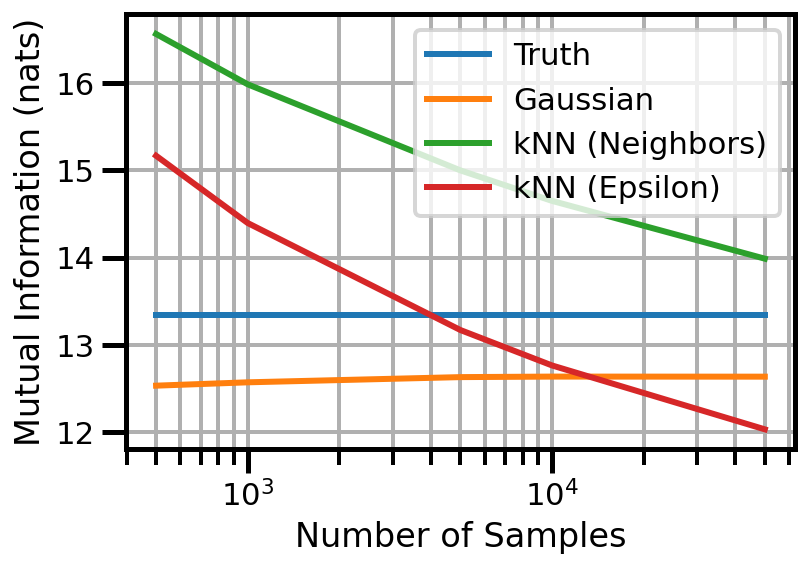

In [39]:
fig, ax = plt.subplots()


stats_ds.sel(n_features=n_features, algorithm="truth").mean(["trial"]).H.plot(
    ax=ax, label="Truth"
)
stats_ds.sel(n_features=n_features, algorithm="gaussian").mean(["trial"]).H.plot(
    ax=ax, label="Gaussian"
)
stats_ds.sel(n_features=n_features, algorithm="knn_nbs").mean(["trial"]).H.plot(
    ax=ax, label="kNN (Neighbors)"
)
stats_ds.sel(n_features=n_features, algorithm="knn_tree").mean(["trial"]).H.plot(
    ax=ax, label="kNN (Epsilon)"
)
# t = stats_ds.sel(n_features=10, algorithm="knn_tree").mean(["trial"]).mi
# t *= np.log(2)
# t.plot(ax=ax, label="kNN (Epsilon)", linewidth=5, linestyle="--")

ax.set(
    xlabel="Number of Samples",
    ylabel="Mutual Information (nats)",
    title="",
    xscale="log",
)
ax.grid(
    True, which="both",
)
ax.legend()
plt.show()

### Compare True Values

In [40]:
def percent_error(real, pred):
    pred = np.abs(np.abs(pred - real) / real)
    return pred


def get_mean_std(ds):
    mean = ds.mean(["trial"])
    std = 1.96 * ds.std(["trial"])
    return mean, std

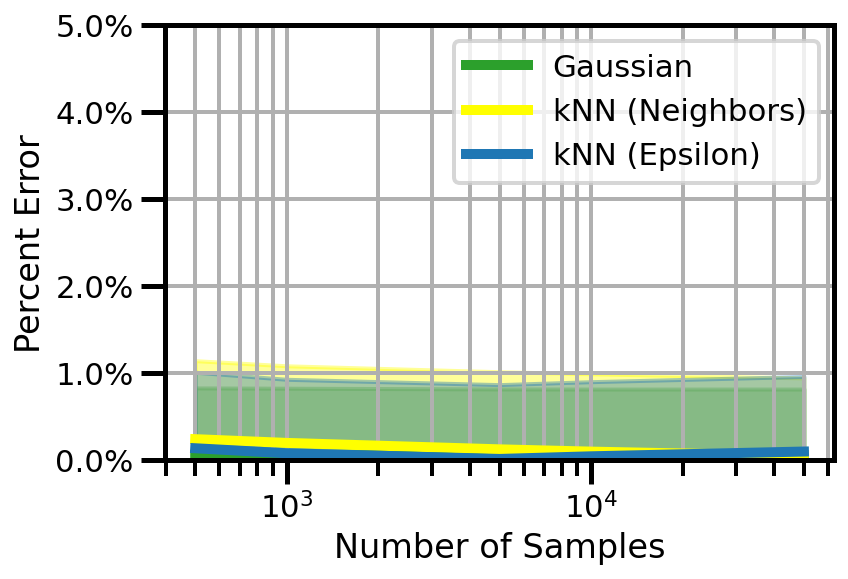

In [43]:
fig, ax = plt.subplots()

real = stats_ds.sel(n_features=10, algorithm="truth").mean(["trial"]).H

# stats_ds.sel(n_features=10, algorithm="truth_nats").mean(["trial"]).H.plot(
#     ax=ax, label="Truth", linewidth=5, color="black"
# )

# ==========================
# GAUSSIAN ESTIMATE
# ==========================
mu, std = get_mean_std(stats_ds.sel(n_features=10, algorithm="gaussian").H)

# calculate percent error
err_mu = percent_error(real, mu)
err_std = percent_error(real, std)

x_data = err_mu.coords["n_samples"].values
y_mu = err_mu.values
ub = y_mu + err_std.values.ravel()
lb = y_mu - err_std.values.ravel()

ax.plot(x_data, y_mu, linewidth=5, linestyle="-", color="tab:green", label="Gaussian")
ax.fill_between(x_data, lb, ub, alpha=0.4, color="tab:green")


# ==========================
# KNN (NEIGHBOURS) ESTIMATE
# ==========================
mu, std = get_mean_std(stats_ds.sel(n_features=10, algorithm="knn_nbs").H)

# calculate percent error
err_mu = percent_error(real, mu)
err_std = percent_error(real, std)

x_data = err_mu.coords["n_samples"].values
y_mu = err_mu.values
ub = y_mu + err_std.values.ravel()
lb = y_mu - err_std.values.ravel()

ax.plot(
    x_data, y_mu, linewidth=5, linestyle="-", color="Yellow", label="kNN (Neighbors)"
)
ax.fill_between(x_data, lb, ub, alpha=0.4, color="Yellow")


# ==========================
# KNN (EPSILON) ESTIMATE
# ==========================
mu, std = get_mean_std(stats_ds.sel(n_features=10, algorithm="knn_tree").H)

# calculate percent error
err_mu = percent_error(real, mu)
err_std = percent_error(real, std)

x_data = err_mu.coords["n_samples"].values
y_mu = err_mu.values
ub = y_mu + err_std.values.ravel()
lb = y_mu - err_std.values.ravel()

ax.plot(
    x_data, y_mu, linewidth=5, linestyle="-", color="tab:blue", label="kNN (Epsilon)"
)
ax.fill_between(x_data, lb, ub, alpha=0.4, color="tab:blue")


ax.set(
    xlabel="Number of Samples",
    ylabel="Percent Error",
    title="",
    xscale="log",
    ylim=[0, 5],
)
import matplotlib.ticker as mtick

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(True, which="both")
ax.legend()
plt.show()

In [38]:
all_stats_ = all_stats.copy()